## A TWO-DIMENSIONAL DIFFERENCE HISTOGRAM EQUALIZATION WITH FUZZY CUMULATIVE DISTRIBUTION CORRECTION FOR DARK IMAGES 

In [ ]:
pip install scikit-fuzzy opencv-python-headless

In [1]:
!pip install piq

^C


In [72]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skfuzzy import cmeans

# 2D Difference Histogram for Image Processing

The **2D Difference Histogram** is a technique used in image processing to capture the intensity differences between a pixel and its surrounding neighborhood. The method works by iterating through each pixel, comparing its value with its neighbors in a local window, and updating a histogram based on the absolute differences in intensity.

The resulting histogram is a 256x256 matrix, where each entry represents the frequency of intensity differences between pixel values in the local neighborhood.

### Applications:
- **Feature extraction**: Captures spatial information and variations in intensity, useful for texture analysis.
- **Edge detection**: Highlights regions with significant intensity differences, identifying sharp boundaries.
- **Texture classification**: Helps in distinguishing texture patterns or identifying objects based on local intensity differences.
- **Pattern recognition**: Can serve as a feature vector for identifying objects or scenes in an image.

This technique is beneficial in tasks where analyzing local differences and textures is important for distinguishing patterns in an image.


In [73]:
def construct_2d_difference_histogram(image, window_size=3):
    """
    Construct the 2D difference histogram for the given image.
    """
    rows, cols, channels = image.shape
    half_window = window_size // 2
    histogram = np.zeros((256, 256))

    for i in range(half_window, rows - half_window):
        for j in range(half_window, cols - half_window):
            for c in range(channels):  # Process each channel separately
                center_pixel = image[i, j, c]
                for k in range(-half_window, half_window + 1):
                    for l in range(-half_window, half_window + 1):
                        if k == 0 and l == 0:
                            continue
                        neighbor_pixel = image[i + k, j + l, c]
                        if center_pixel != neighbor_pixel:  # Different-value gray-level pair
                            histogram[center_pixel, neighbor_pixel] += abs(center_pixel - neighbor_pixel)
    return histogram

The **normalize_histogram** function normalizes a given histogram by dividing each value by the sum of all histogram values, converting it into a probability distribution. This ensures that the sum of all values in the histogram is equal to 1, making it suitable for statistical analysis and image processing tasks. The normalized histogram can then be used in various algorithms, such as image equalization and texture analysis.


In [74]:
def normalize_histogram(histogram):
    """
    Normalize the histogram to obtain probabilities.
    """
    return histogram / np.sum(histogram)

The **calculate_cumulative_distribution** function computes the cumulative distribution function (CDF) from a given histogram. It does this by calculating the cumulative sum of the histogram values, which represents the cumulative probability distribution. The CDF is reshaped to match the shape of the original histogram for further use in image processing or statistical analysis.


In [75]:
def calculate_cumulative_distribution(histogram):
    """
    Compute the cumulative distribution function (CDF).
    """
    return np.cumsum(histogram.flatten()).reshape(histogram.shape)

The **fuzzy_clustering** function applies fuzzy c-means clustering to a given cumulative distribution function (CDF). It flattens the CDF, removes zeros to avoid issues during clustering, and then applies the c-means algorithm to partition the data into a specified number of clusters. The function returns the cluster centers (`cntr`) and membership values (`u`), which can be used for further analysis or adjustments in image processing.


In [76]:
def fuzzy_clustering(cdf, num_clusters=5):
    """
    Apply fuzzy c-means clustering to the cumulative distribution function.
    """
    flat_cdf = cdf.flatten()
    flat_cdf = flat_cdf[flat_cdf > 0]  # Remove zeros for clustering
    cntr, u, _, _, _, _, _ = cmeans(flat_cdf.reshape(1, -1), num_clusters, 2, error=0.005, maxiter=1000)
    return cntr, u

The **apply_fuzzy_correction** function adjusts the cumulative distribution function (CDF) using results from fuzzy c-means clustering. It applies cluster-based correction factors (from cntr) to the non-zero values of the flattened CDF, where the cluster membership (u) determines the dominant correction factor for each value. After applying the corrections, the modified CDF is reshaped to its original 2D form and normalized to ensure values remain within the range [0, 1]. This corrected CDF is then used for smoother and more accurate intensity mapping in image enhancement.

In [77]:
def apply_fuzzy_correction(cdf, cntr, u):
    """
    Correct the cumulative distribution function using fuzzy clustering results.
    """
    corrected_cdf = np.zeros_like(cdf)
    flat_cdf = cdf.flatten()

    # Get indices of non-zero values
    non_zero_indices = np.where(flat_cdf > 0)[0]

    for idx, cdf_idx in enumerate(non_zero_indices):
        cluster_idx = np.argmax(u[:, idx])  # Use the index from non-zero data
        correction_factor = cntr[cluster_idx]
        flat_cdf[cdf_idx] *= correction_factor

    corrected_cdf = flat_cdf.reshape(cdf.shape)
    return corrected_cdf / corrected_cdf.max()  # Normalize corrected CDF

The **equalize_image** function enhances an image using the corrected cumulative distribution function (CDF). It first normalizes the corrected CDF to map the values to pixel intensities, and then applies this mapping to each pixel in the image. The function processes each color channel independently, updating the pixel values to improve contrast based on the corrected CDF, resulting in an equalized image with enhanced features.


In [78]:
def equalize_image(image, corrected_cdf):
    """
    Equalize the image using the corrected cumulative distribution function.
    """
    rows, cols, channels = image.shape
    equalized_image = np.zeros_like(image, dtype=np.uint8)

    # Normalize corrected CDF to map to pixel intensities
    cdf_map = (corrected_cdf * 255).astype(np.uint8)

    for i in range(rows):
        for j in range(cols):
            for c in range(channels):  # Apply to each channel
                equalized_image[i, j, c] = cdf_map[image[i, j, c], image[i, j, c]]

    return equalized_image

The **enhance_image** function implements the complete pipeline for enhancing a dark image using a proposed methodology. The function follows these steps:
1. **Construct 2D Difference Histogram**: Computes the 2D histogram to capture pixel intensity differences.
2. **Normalize Histogram**: Normalizes the histogram to create a probability distribution and computes the cumulative distribution.
3. **Fuzzy Clustering**: Applies fuzzy c-means clustering to the cumulative distribution for improved correction.
4. **Fuzzy Correction**: Adjusts the cumulative distribution using the clustering results.
5. **Equalization**: Enhances the image by equalizing it with the corrected cumulative distribution.

The enhanced image is then saved and returned alongside the original image for comparison.


In [79]:
def proposed_image(image_path):
    """
    Complete pipeline to enhance a dark image using the proposed methodology.
    """
    # Load the color image in RGB (convert from BGR as loaded by OpenCV)
    image = cv2.imread(image_path)

    # Step 1: Construct 2D difference histogram
    histogram = construct_2d_difference_histogram(image)

    # Step 2: Normalize histogram and compute cumulative distribution
    normalized_histogram = normalize_histogram(histogram)
    cdf = calculate_cumulative_distribution(normalized_histogram)

    # Step 3: Perform fuzzy clustering on the cumulative distribution
    cntr, u = fuzzy_clustering(cdf)

    # Step 4: Apply fuzzy correction to the cumulative distribution
    corrected_cdf = apply_fuzzy_correction(cdf, cntr, u)

    # Step 5: Equalize the image using the corrected CDF
    enhanced_image = equalize_image(image, corrected_cdf)

    # Save the enhanced image
#     cv2.imwrite(output_path, enhanced_image)
#     print(f"Enhanced image saved at: {output_path}")

    return enhanced_image  # Return both the input and enhanced images

C:\Users\P.BHANU PRANASWI SAI\AppData\Local\Temp\ipykernel_10668\4154709018.py:19: RuntimeWarning: overflow encountered in scalar subtract
  histogram[center_pixel, neighbor_pixel] += abs(center_pixel - neighbor_pixel)
C:\Users\P.BHANU PRANASWI SAI\AppData\Local\Temp\ipykernel_10668\1176950917.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  flat_cdf[cdf_idx] *= correction_factor


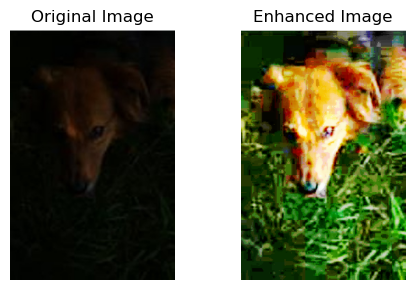

In [80]:
# Usage
input_image_path = "dog_img.jpg" 
input_image = cv2.imread(input_image_path)

# Get the input and enhanced images
enhanced_image = proposed_image(input_image_path)

# Show input and enhanced images side by side using matplotlib
plt.figure(figsize=(5, 3))

# Show original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
plt.title('Original Image')
plt.axis('off')

# Show enhanced image
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
plt.title('Enhanced Image')
plt.axis('off')

# Display the images
plt.tight_layout()
plt.show()

## Image Enhancement and Quality Metrics

This notebook applies several image enhancement techniques to a given image and evaluates the enhanced results using different quality metrics: **Mean Value (MV)**, **Measure of Enhancement (EME)**, and **Natural Image Quality Evaluator (NIQE)**.

### Enhancement Techniques Used:
1. **Brightness Preserving Bi-Histogram Equalization (BBHE)**:
   - This technique divides the image into two parts (below and above the mean intensity) and applies histogram equalization independently to preserve brightness while enhancing contrast.
  
2. **2D Histogram Equalization (2DHE)**:
   - The histogram is calculated based on pixel pairs, and a cumulative distribution is computed for the image's intensities, which is used to map the pixel values to enhance the image.
  
3. **Contrast Limited Adaptive Histogram Equalization (CLAHE)**:
   - A local version of histogram equalization that enhances small regions of an image, typically used for improving contrast in specific areas like low-light regions.
  
4. **Simultaneous Reflectance and Illumination Estimation (SRIE)**:
   - An image enhancement technique that separates an image into reflectance and illumination components to improve contrast, especially in low-light conditions.

5. **Low-light Enhancement by Contrast-Adaptive Retinex Model (LECARM)**:
   - A method based on the Retinex theory, which enhances the image by improving the contrast in low-light regions, making the details more visible.
  
### Quality Metrics:
- **Mean Value (MV)**: Measures the average pixel intensity. A higher value indicates a brighter image.
- **Measure of Enhancement (EME)**: Evaluates the local dynamic range of an image, giving insight into how well the contrast is enhanced.
- **Natural Image Quality Evaluator (NIQE)**: A perceptual quality measure based on the image's statistical properties. A lower NIQE score indicates better visual quality, consistent with human perception.

### Example Image Enhancements and Results:
1. **Original Image** vs Enhanced Images using different methods.
2. **Quality Metrics** for each enhancement technique are printed out for comparison.

Each enhancement technique is applied to the image, and the resulting images are displayed alongside their corresponding quality metrics.

### Steps:
1. **BBHE**: Preserves brightness while enhancing contrast.
2. **2DHE**: Applies equalization to the 2D histogram for better contrast and feature visibility.
3. **CLAHE**: Enhances local contrast in specific regions of the image.
4. **SRIE and LECARM**: Improve image contrast by separating reflectance and illumination.
5. **Metrics Calculation**: MV, EME, and NIQE are computed to assess the effectiveness of each enhancement method.

The final output includes the comparison of the original image with the enhanced images and their quality scores.


In [81]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# 1. Brightness Preserving Bi-Histogram Equalization (BBHE)
def bbhe(v):
    """
    Brightness Preserving Bi-Histogram Equalization (BBHE)
    """
    mean_intensity = int(np.mean(v))  # Compute the mean intensity as a threshold
    lower_mask = v <= mean_intensity  # Pixels below or equal to the mean
    upper_mask = v > mean_intensity   # Pixels above the mean

    # Initialize result array
    result = np.zeros_like(v)

    # Apply histogram equalization to the lower part
    if np.any(lower_mask):
        lower_part = v[lower_mask].flatten()
        lower_eq = cv2.equalizeHist(lower_part)
        result[lower_mask] = lower_eq.reshape(result[lower_mask].shape)

    # Apply histogram equalization to the upper part
    if np.any(upper_mask):
        upper_part = v[upper_mask].flatten()
        upper_eq = cv2.equalizeHist(upper_part)
        result[upper_mask] = upper_eq.reshape(result[upper_mask].shape)

    return result

def two_dhe(v):
    """
    Perform 2D Histogram Equalization (2DHE) on the input image.

    Parameters:
    - v: Input grayscale image (numpy array).

    Returns:
    - result: Enhanced image after applying 2DHE.
    """
    # Initialize a 2D histogram
    histogram_2d = np.zeros((256, 256), dtype=int)
    h, w = v.shape

    # Compute the 2D histogram based on pixel pairs
    for i in range(h - 1):
        for j in range(w - 1):
            current_pixel = v[i, j]
            neighbor_pixel = v[i + 1, j + 1]
            histogram_2d[current_pixel, neighbor_pixel] += 1

    # Flatten the histogram along one dimension and compute the cumulative sum
    cumulative_histogram = np.cumsum(histogram_2d.sum(axis=1))
    cumulative_histogram_normalized = (cumulative_histogram / cumulative_histogram[-1]) * 255

    # Create the LUT (mapping array) for intensity transformation
    mapping = np.clip(cumulative_histogram_normalized, 0, 255).astype(np.uint8)

    # Map the input image through the LUT
    result = cv2.LUT(v, mapping)

    return result

# 3. Contrast Limited Adaptive Histogram Equalization (CLAHE)
def apply_clahe(v, clip_limit=2.0, tile_grid_size=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(v)

# 4. Simultaneous Reflectance and Illumination Estimation (SRIE)
def srie(v, lambda_val=0.01, sigma=2):
    log_v = np.log1p(v.astype('float32'))
    illumination = cv2.GaussianBlur(log_v, (0, 0), sigma)
    reflectance = log_v - illumination
    enhanced_reflectance = reflectance * lambda_val
    enhanced_v = np.expm1(illumination + enhanced_reflectance)
    enhanced_v = cv2.normalize(enhanced_v, None, 0, 255, cv2.NORM_MINMAX)
    return enhanced_v.astype('uint8')

# 5. Low-light Enhancement by Contrast-Adaptive Retinex Model (LECARM)
def lecarm(v):
    log_v = np.log1p(v.astype('float32') / 255.0)
    enhanced_log = cv2.GaussianBlur(log_v, (5, 5), 0)
    return cv2.normalize(np.expm1(enhanced_log), None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

# Quality Metrics
def mean_value(image):
    return np.mean(image)

def measure_of_enhancement(image, k=7):
    h, w = image.shape
    window_h, window_w = h // k, w // k
    eme = 0
    for i in range(k):
        for j in range(k):
            local_window = image[i * window_h:(i + 1) * window_h, j * window_w:(j + 1) * window_w]
            min_val = np.min(local_window)
            max_val = np.max(local_window)
            if min_val > 0:
                eme += 20 * np.log10(max_val / min_val)
    return eme / (k * k)

def calculate_niqe(image):
    """
    Calculate NIQE (Natural Image Quality Evaluator).
    Approximates NIQE using Gaussian filtering and local statistics.

    Parameters:
    - image: Input grayscale image (numpy array).

    Returns:
    - niqe_score: Approximated NIQE score.
    """
    image = image.astype('float32') / 255.0  # Normalize the image to [0, 1]
    mu = gaussian_filter(image, sigma=7)  # Local mean
    sigma_sq = gaussian_filter(image**2, sigma=7) - mu**2  # Local variance
    sharpness = np.var(image - gaussian_filter(image, sigma=1))  # Sharpness

    # Combine metrics with weights to approximate NIQE
    niqe_score = np.mean(sigma_sq) + 0.5 * np.mean(mu) + 2 * sharpness
    return niqe_score

def enhance_image(image_path):
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)

    # Apply Enhancement Techniques
    he_image = cv2.merge((h, s, cv2.equalizeHist(v)))
    bbhe_image = cv2.merge((h, s, bbhe(v.copy())))
    clahe_image = cv2.merge((h, s, apply_clahe(v.copy())))
    srie_image = cv2.merge((h, s, srie(v.copy())))
    lecarm_image = cv2.merge((h, s, lecarm(v.copy())))
    two_dhe_image = cv2.merge((h, s, two_dhe(v.copy())))

    # Apply the proposed image enhancement
    proposed_enhanced = proposed_image(image_path)
    proposed_enhanced = cv2.cvtColor(proposed_enhanced, cv2.COLOR_BGR2RGB)

    # Convert back to RGB
    he_image = cv2.cvtColor(he_image, cv2.COLOR_HSV2RGB)
    bbhe_image = cv2.cvtColor(bbhe_image, cv2.COLOR_HSV2RGB)
    clahe_image = cv2.cvtColor(clahe_image, cv2.COLOR_HSV2RGB)
    srie_image = cv2.cvtColor(srie_image, cv2.COLOR_HSV2RGB)
    lecarm_image = cv2.cvtColor(lecarm_image, cv2.COLOR_HSV2RGB)
    two_dhe_image = cv2.cvtColor(two_dhe_image, cv2.COLOR_HSV2RGB)

    # List of all images and their titles
    images = [image, he_image, bbhe_image, clahe_image, two_dhe_image, lecarm_image, srie_image, proposed_enhanced]
    titles = ["Original", "HE", "BBHE", "CLAHE", "2DHE", "LECARM", "SRIE", "Proposed"]

    # Metrics Evaluation
    print("\nQuality Metrics (MV, EME, NIQE):")
    for title, img in zip(titles, images):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mv = mean_value(gray)
        eme = measure_of_enhancement(gray)
        niqe_score = calculate_niqe(gray)
        print(f"{title}: MV={mv:.2f}, EME={eme:.2f}, NIQE={niqe_score:.2f}")

    # Display all results
    plt.figure(figsize=(16, 6))  # Adjust the figure size for 1x8 layout
    for i, (title, img) in enumerate(zip(titles, images), 1):
        plt.subplot(1, 8, i)
        plt.title(title)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

C:\Users\P.BHANU PRANASWI SAI\AppData\Local\Temp\ipykernel_10668\4154709018.py:19: RuntimeWarning: overflow encountered in scalar subtract
  histogram[center_pixel, neighbor_pixel] += abs(center_pixel - neighbor_pixel)
C:\Users\P.BHANU PRANASWI SAI\AppData\Local\Temp\ipykernel_10668\1176950917.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  flat_cdf[cdf_idx] *= correction_factor



Quality Metrics (MV, EME, NIQE):
Original: MV=9.49, EME=19.55, NIQE=0.02
HE: MV=100.84, EME=25.92, NIQE=0.22
BBHE: MV=102.95, EME=2.01, NIQE=0.26
CLAHE: MV=21.58, EME=30.00, NIQE=0.05
2DHE: MV=100.38, EME=26.45, NIQE=0.22
LECARM: MV=24.47, EME=24.17, NIQE=0.05
SRIE: MV=23.52, EME=20.07, NIQE=0.05
Proposed: MV=87.59, EME=29.45, NIQE=0.20


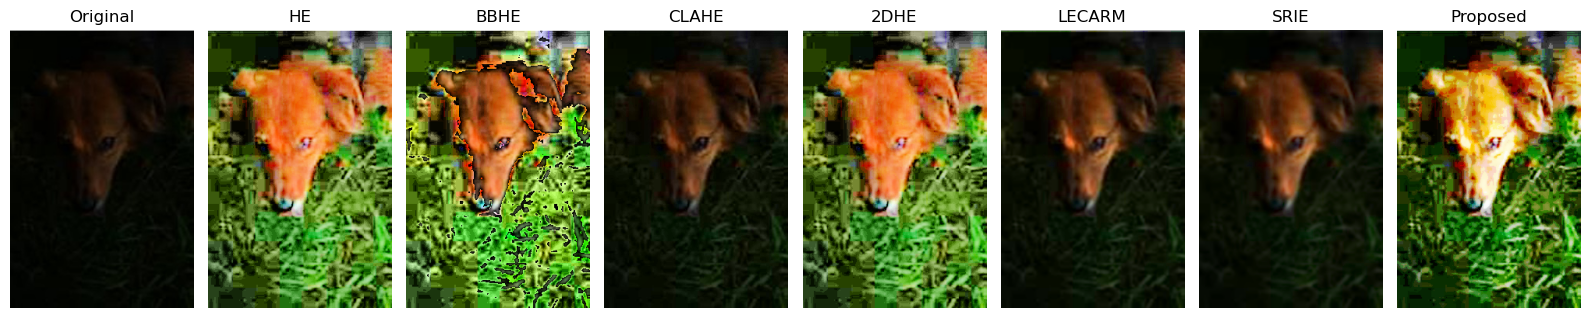

In [82]:
# Run the script
enhance_image("dog_img.jpg")

C:\Users\P.BHANU PRANASWI SAI\AppData\Local\Temp\ipykernel_10668\4154709018.py:19: RuntimeWarning: overflow encountered in scalar subtract
  histogram[center_pixel, neighbor_pixel] += abs(center_pixel - neighbor_pixel)
C:\Users\P.BHANU PRANASWI SAI\AppData\Local\Temp\ipykernel_10668\1176950917.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  flat_cdf[cdf_idx] *= correction_factor



Quality Metrics (MV, EME, NIQE):
Original: MV=10.77, EME=15.00, NIQE=0.03
HE: MV=115.77, EME=16.63, NIQE=0.27
BBHE: MV=114.63, EME=10.29, NIQE=0.29
CLAHE: MV=18.19, EME=18.86, NIQE=0.05
2DHE: MV=115.76, EME=16.05, NIQE=0.27
LECARM: MV=14.69, EME=16.91, NIQE=0.04
SRIE: MV=30.79, EME=16.58, NIQE=0.07
Proposed: MV=57.90, EME=10.86, NIQE=0.16


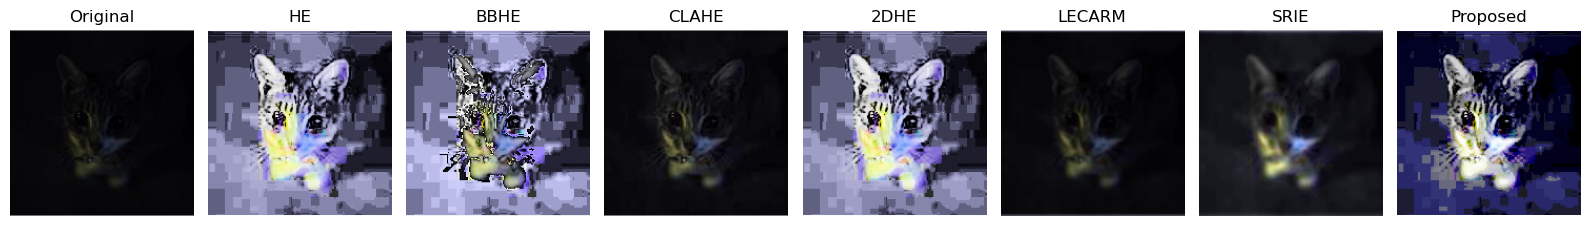

In [83]:
# Run the script
enhance_image("cat_im.jpg")

C:\Users\P.BHANU PRANASWI SAI\AppData\Local\Temp\ipykernel_10668\4154709018.py:19: RuntimeWarning: overflow encountered in scalar subtract
  histogram[center_pixel, neighbor_pixel] += abs(center_pixel - neighbor_pixel)
C:\Users\P.BHANU PRANASWI SAI\AppData\Local\Temp\ipykernel_10668\1176950917.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  flat_cdf[cdf_idx] *= correction_factor



Quality Metrics (MV, EME, NIQE):
Original: MV=11.24, EME=9.18, NIQE=0.03
HE: MV=118.27, EME=3.74, NIQE=0.26
BBHE: MV=119.24, EME=0.20, NIQE=0.29
CLAHE: MV=22.97, EME=29.51, NIQE=0.05
2DHE: MV=120.96, EME=25.70, NIQE=0.26
LECARM: MV=10.53, EME=11.41, NIQE=0.03
SRIE: MV=12.10, EME=13.43, NIQE=0.03
Proposed: MV=81.34, EME=7.81, NIQE=0.19


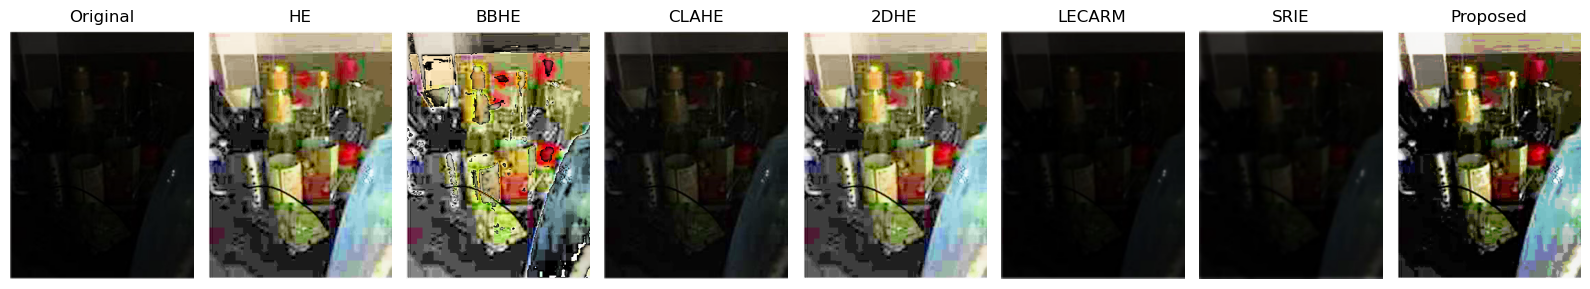

In [70]:
# Run the script
enhance_image("bottles.jpg")

C:\Users\P.BHANU PRANASWI SAI\AppData\Local\Temp\ipykernel_10668\4154709018.py:19: RuntimeWarning: overflow encountered in scalar subtract
  histogram[center_pixel, neighbor_pixel] += abs(center_pixel - neighbor_pixel)
C:\Users\P.BHANU PRANASWI SAI\AppData\Local\Temp\ipykernel_10668\1176950917.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  flat_cdf[cdf_idx] *= correction_factor



Quality Metrics (MV, EME, NIQE):
Original: MV=9.22, EME=8.06, NIQE=0.02
HE: MV=127.20, EME=18.20, NIQE=0.29
BBHE: MV=128.23, EME=3.39, NIQE=0.34
CLAHE: MV=23.39, EME=29.45, NIQE=0.05
2DHE: MV=127.01, EME=18.15, NIQE=0.29
LECARM: MV=16.68, EME=23.49, NIQE=0.03
SRIE: MV=19.66, EME=21.22, NIQE=0.04
Proposed: MV=62.85, EME=14.43, NIQE=0.16


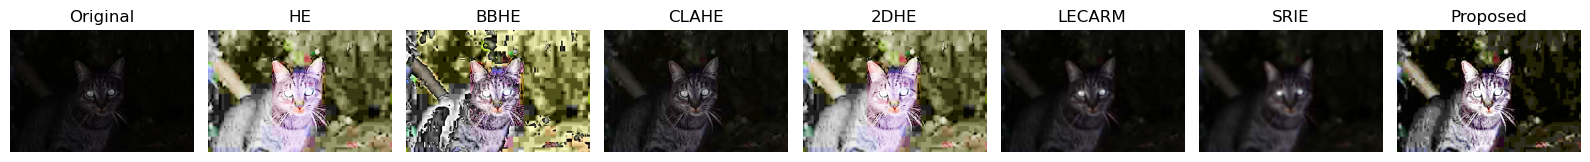

In [32]:
enhance_image("cat.jpeg")

C:\Users\P.BHANU PRANASWI SAI\AppData\Local\Temp\ipykernel_10668\4154709018.py:19: RuntimeWarning: overflow encountered in scalar subtract
  histogram[center_pixel, neighbor_pixel] += abs(center_pixel - neighbor_pixel)
C:\Users\P.BHANU PRANASWI SAI\AppData\Local\Temp\ipykernel_10668\1176950917.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  flat_cdf[cdf_idx] *= correction_factor



Quality Metrics (MV, EME, NIQE):
Original: MV=59.38, EME=22.27, NIQE=0.12
HE: MV=112.15, EME=15.37, NIQE=0.22
BBHE: MV=111.19, EME=5.76, NIQE=0.24
CLAHE: MV=76.00, EME=25.75, NIQE=0.15
2DHE: MV=111.86, EME=15.51, NIQE=0.22
LECARM: MV=58.16, EME=23.96, NIQE=0.12
SRIE: MV=60.29, EME=22.66, NIQE=0.12
Proposed: MV=56.13, EME=10.38, NIQE=0.12


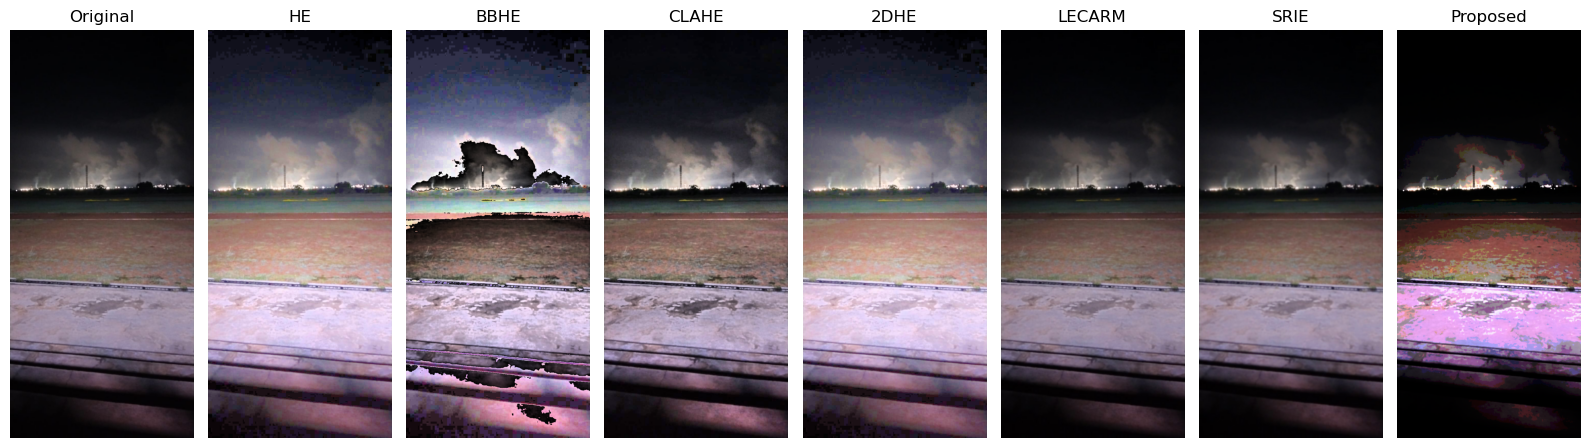

In [33]:
enhance_image("dark_area.jpg")

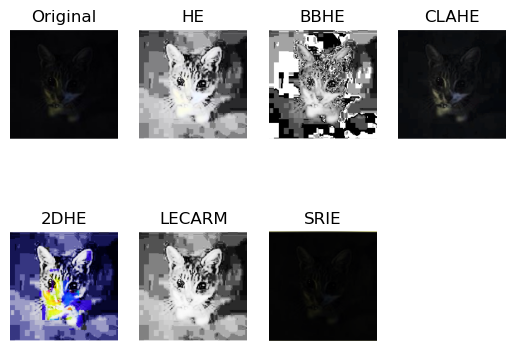

In [21]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# # Load the original image
# image_path = "cat_im.jpg"  # Replace with the path to your input image
# original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
# original_image = cv2.cvtColor(orginal_image, cv2.COLOR_BGR2RGB)

# # HE: Histogram Equalization
# def apply_he(image):
#     image_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
#     image_yuv[:, :, 0] = cv2.equalizeHist(image_yuv[:, :, 0])
#     return cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)

# # BBHE: Bi-Histogram Equalization
# def apply_bbhe(image):
#     gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     median = np.median(gray)
    
#     # Create masks for lower and higher intensity ranges
#     low_mask = gray <= median
#     high_mask = gray > median
    
#     # Equalize the two parts separately
#     low_part = gray[low_mask]
#     high_part = gray[high_mask]
#     low_eq = cv2.equalizeHist(low_part)
#     high_eq = cv2.equalizeHist(high_part)
    
#     # Create a new image and merge the equalized parts
#     equalized = np.zeros_like(gray)
#     equalized[low_mask] = low_eq.flatten()
#     equalized[high_mask] = high_eq.flatten()
    
#     return cv2.cvtColor(equalized, cv2.COLOR_GRAY2RGB)


# # CLAHE: Contrast Limited Adaptive Histogram Equalization
# def apply_clahe(image):
#     lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#     lab[:, :, 0] = clahe.apply(lab[:, :, 0])
#     return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

# # 2DHE: 2D Histogram Equalization
# def apply_2dhe(image):
#     hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#     h, s, v = cv2.split(hsv)
#     eq_s = cv2.equalizeHist(s)
#     eq_v = cv2.equalizeHist(v)
#     eq_hsv = cv2.merge([h, eq_s, eq_v])
#     return cv2.cvtColor(eq_hsv, cv2.COLOR_HSV2RGB)

# # LECARM: Low-Exposure Contrast Adjustment with Regularization Model
# def apply_lecarm(image):
#     gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     enhanced_gray = cv2.equalizeHist(gray)
#     return cv2.cvtColor(enhanced_gray, cv2.COLOR_GRAY2RGB)

# # SRIE: Single-Scale Retinex Image Enhancement
# def apply_srie(image):
#     log_image = np.log1p(image.astype(np.float32))
#     retinex = log_image - cv2.GaussianBlur(log_image, (81, 81), 30)
#     retinex = np.exp(retinex) - 1
#     retinex = (retinex - retinex.min()) / (retinex.max() - retinex.min()) * 255
#     return retinex.astype(np.uint8)

# # output_image_path = "cat_new.jpg"

# # Generate the enhanced images
# he_image = apply_he(original_image)
# bbhe_image = apply_bbhe(original_image)
# clahe_image = apply_clahe(original_image)
# d2he_image = apply_2dhe(original_image)
# lecarm_image = apply_lecarm(original_image)
# srie_image = apply_srie(original_image)
# # original_image, proposed_image = enhance_image(original_image, output_image_path)

# # Display the results
# titles = ['Original', 'HE', 'BBHE', 'CLAHE', '2DHE', 'LECARM', 'SRIE']
# images = [original_image, he_image, bbhe_image, clahe_image, d2he_image, lecarm_image, srie_image]

# for i in range(len(images)):
#     plt.subplot(2, 4, i + 1)
#     plt.imshow(images[i])
#     plt.title(titles[i])
#     plt.axis('off')

# plt.show()

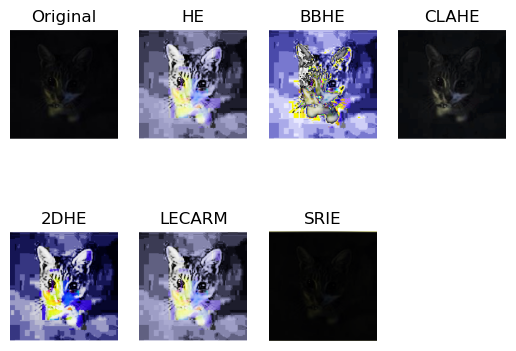

In [39]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# # Load the original image
# image_path = "cat_im.jpg"  # Replace with the path to your input image
# original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
# original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# # HE: Histogram Equalization
# def apply_he(image):
#     hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#     h, s, v = cv2.split(hsv)
#     v = cv2.equalizeHist(v)
#     he_hsv = cv2.merge([h, s, v])
#     return cv2.cvtColor(he_hsv, cv2.COLOR_HSV2RGB)

# # BBHE: Bi-Histogram Equalization
# def apply_bbhe(v):
#     """
#     Apply Bi-Histogram Equalization (BBHE) on the V channel of the image in HSV color space.
#     Args:
#         image: Input RGB image.
#     Returns:
#         RGB image after BBHE enhancement.
#     """
#     mean_intensity = int(np.mean(v))  # Compute the mean intensity as a threshold
#     lower_mask = v <= mean_intensity  # Pixels below or equal to the mean
#     upper_mask = v > mean_intensity   # Pixels above the mean

#     # Initialize result array
#     result = np.zeros_like(v, dtype=np.uint8)

#     # Apply histogram equalization to the lower part
#     if np.any(lower_mask):
#         lower_part = v[lower_mask].flatten().astype(np.uint8)  # Flatten the lower part
#         lower_eq = cv2.equalizeHist(lower_part)
#         result[lower_mask] = lower_eq.reshape(result[lower_mask].shape)

#     # Apply histogram equalization to the upper part
#     if np.any(upper_mask):
#         upper_part = v[upper_mask].flatten().astype(np.uint8)  # Flatten the upper part
#         upper_eq = cv2.equalizeHist(upper_part)
#         result[upper_mask] = upper_eq.reshape(result[upper_mask].shape)

#     return result

# # CLAHE: Contrast Limited Adaptive Histogram Equalization
# def apply_clahe(image):
#     lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
#     l, a, b = cv2.split(lab)
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#     l = clahe.apply(l)
#     clahe_lab = cv2.merge([l, a, b])
#     return cv2.cvtColor(clahe_lab, cv2.COLOR_LAB2RGB)

# # 2DHE: 2D Histogram Equalization
# def apply_2dhe(image):
#     hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#     h, s, v = cv2.split(hsv)
#     s = cv2.equalizeHist(s)
#     v = cv2.equalizeHist(v)
#     eq_hsv = cv2.merge([h, s, v])
#     return cv2.cvtColor(eq_hsv, cv2.COLOR_HSV2RGB)

# # LECARM: Low-Exposure Contrast Adjustment with Regularization Model
# def apply_lecarm(image):
#     hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#     h, s, v = cv2.split(hsv)
#     v = cv2.equalizeHist(v)
#     lecarm_hsv = cv2.merge([h, s, v])
#     return cv2.cvtColor(lecarm_hsv, cv2.COLOR_HSV2RGB)

# # SRIE: Single-Scale Retinex Image Enhancement
# def apply_srie(image):
#     log_image = np.log1p(image.astype(np.float32))
#     retinex = log_image - cv2.GaussianBlur(log_image, (81, 81), 30)
#     retinex = np.exp(retinex) - 1
#     retinex = (retinex - retinex.min()) / (retinex.max() - retinex.min()) * 255
#     return retinex.astype(np.uint8)

# # Generate the enhanced images
# he_image = apply_he(original_image)
# bbhe_image = apply_bbhe(original_image)
# clahe_image = apply_clahe(original_image)
# d2he_image = apply_2dhe(original_image)
# lecarm_image = apply_lecarm(original_image)
# srie_image = apply_srie(original_image)

# # Display the results
# titles = ['Original', 'HE', 'BBHE', 'CLAHE', '2DHE', 'LECARM', 'SRIE']
# images = [original_image, he_image, bbhe_image, clahe_image, d2he_image, lecarm_image, srie_image]

# for i in range(len(images)):
#     plt.subplot(2, 4, i + 1)
#     plt.imshow(images[i])
#     plt.title(titles[i])
#     plt.axis('off')

# plt.show()


C:\Users\P.BHANU PRANASWI SAI\AppData\Local\Temp\ipykernel_18024\4154709018.py:19: RuntimeWarning: overflow encountered in scalar subtract
  histogram[center_pixel, neighbor_pixel] += abs(center_pixel - neighbor_pixel)
C:\Users\P.BHANU PRANASWI SAI\AppData\Local\Temp\ipykernel_18024\1176950917.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  flat_cdf[cdf_idx] *= correction_factor


Enhanced image saved at: enhanced_image_cat_rgb.jpg


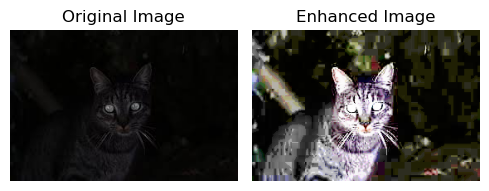

In [12]:
# # Usage
# input_image_path = "cat.jpeg"  # Replace with your image path
# output_image_path = "enhanced_image_cat_rgb.jpg"

# # Get the input and enhanced images
# input_image, enhanced_image = enhance_image(input_image_path, output_image_path)

# # Show input and enhanced images side by side using matplotlib
# plt.figure(figsize=(5, 3))

# # Show original image
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
# plt.title('Original Image')
# plt.axis('off')

# # Show enhanced image
# plt.subplot(1, 2, 2)
# plt.imshow(cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
# plt.title('Enhanced Image')
# plt.axis('off')

# # Display the images
# plt.tight_layout()
# plt.show()

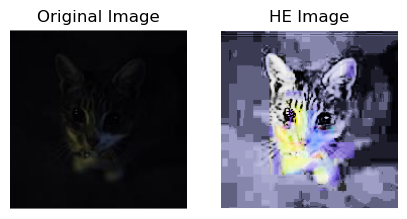

In [3]:
# import cv2cat_im
# import matplotlib.pyplot as plt

# # Read the colored image
# image = cv2.imread("cat_im.jpg")
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# # Convert to HSV color space
# hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
# h, s, v = cv2.split(hsv)

# # Apply HE on the Value channel
# v_eq = cv2.equalizeHist(v)

# # Merge back and convert to RGB
# hsv_eq = cv2.merge((h, s, v_eq))
# he_image = cv2.cvtColor(hsv_eq, cv2.COLOR_HSV2RGB)

# # Display the original and HE images
# plt.figure(figsize=(5, 3))
# plt.subplot(1, 2, 1)
# plt.title("Original Image")
# plt.imshow(image)
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.title("HE Image")
# plt.imshow(he_image)
# plt.axis('off')
# plt.show()

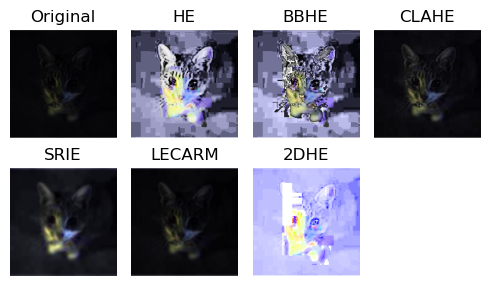

In [2]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# import skfuzzy as fuzz

# # 1. Brightness Preserving Bi-Histogram Equalization (BBHE)
# def bbhe(v):
#     mean_intensity = np.mean(v)
#     lower_mask = v <= mean_intensity
#     upper_mask = v > mean_intensity
#     lower_v = v.copy()
#     upper_v = v.copy()
#     lower_v[~lower_mask] = 0
#     upper_v[~upper_mask] = 0
#     lower_eq = cv2.equalizeHist(lower_v)
#     upper_eq = cv2.equalizeHist(upper_v)
#     v_result = lower_eq + upper_eq
#     return v_result

# # 2. Contrast Limited Adaptive Histogram Equalization (CLAHE)
# def apply_clahe(v, clip_limit=2.0, tile_grid_size=(8, 8)):
#     clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
#     return clahe.apply(v)

# # 3. Placeholder for SRIE (requires specialized library)
# def srie(v, lambda_val=0.01, sigma=2):
#     """
#     Simultaneous Reflectance and Illumination Estimation (SRIE) approximation.
    
#     Parameters:
#     - v: Input Value (brightness) channel.
#     - lambda_val: Regularization parameter (controls smoothing).
#     - sigma: Standard deviation for Gaussian smoothing.
    
#     Returns:
#     - Enhanced Value channel.
#     """
#     # Convert Value channel to logarithmic domain
#     log_v = np.log1p(v.astype('float32'))

#     # Estimate illumination using Gaussian filtering
#     illumination = cv2.GaussianBlur(log_v, (0, 0), sigma)

#     # Estimate reflectance
#     reflectance = log_v - illumination

#     # Enhance the reflectance
#     enhanced_reflectance = reflectance * lambda_val

#     # Reconstruct the Value channel
#     enhanced_v = np.expm1(illumination + enhanced_reflectance)
#     enhanced_v = cv2.normalize(enhanced_v, None, 0, 255, cv2.NORM_MINMAX)
#     return enhanced_v.astype('uint8')

# # 4. Low-light Enhancement by Contrast-Adaptive Retinex Model (LECARM)
# def lecarm(v):
#     log_v = np.log1p(v.astype('float32') / 255.0)
#     enhanced_log = cv2.GaussianBlur(log_v, (5, 5), 0)
#     return cv2.normalize(np.expm1(enhanced_log), None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

# # 5. 2D Histogram Equalization (2DHE)
# def two_dhe(v, window_size=7):
#     histogram = np.zeros((256, 256))
#     M, N = v.shape
#     pad_size = window_size // 2
#     padded_v = np.pad(v, pad_size, mode='reflect')
#     for i in range(M):
#         for j in range(N):
#             center = v[i, j]
#             local_window = padded_v[i:i + window_size, j:j + window_size]
#             for k in range(window_size):
#                 for l in range(window_size):
#                     neighbor = local_window[k, l]
#                     histogram[center, neighbor] += 1
#     cumulative = np.cumsum(histogram.sum(axis=0))
#     mapping = np.interp(np.arange(256), np.linspace(0, 1, 256), cumulative)
#     return cv2.LUT(v, mapping.clip(0, 255).astype('uint8'))

# # # 6. Proposed Method (2DDHE with Fuzzy Correction)
# # def proposed_method(v, window_size=7, num_clusters=5):
# #     histogram = np.zeros((256, 256))
# #     M, N = v.shape
# #     pad_size = window_size // 2
# #     padded_v = np.pad(v, pad_size, mode='reflect')
# #     for i in range(M):
# #         for j in range(N):
# #             center = v[i, j]
# #             local_window = padded_v[i:i + window_size, j:j + window_size]
# #             for k in range(window_size):
# #                 for l in range(window_size):
# #                     neighbor = local_window[k, l]
# #                     if center != neighbor:
# #                         histogram[center, neighbor] += 1
# #     normalized = histogram / histogram.sum()
# #     cumulative = np.cumsum(normalized.sum(axis=0))
# #     cumulative = cumulative.reshape(-1, 1)
# #     centers, u, _, _, _, _, _ = fuzz.cluster.cmeans(
# #         data=cumulative.T, c=num_clusters, m=2, error=0.005, maxiter=1000
# #     )
# #     corrected = np.dot(u.T, centers).flatten()
# #     mapping = np.interp(np.arange(256), np.linspace(0, 1, 256), corrected)
# #     return cv2.LUT(v, mapping.clip(0, 255).astype('uint8'))

# # Main Script
# def enhance_image(image_path):
#     # Read the image
#     image = cv2.imread(image_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#     h, s, v = cv2.split(hsv)

#     # Apply Enhancement Techniques
#     he_image = cv2.merge((h, s, cv2.equalizeHist(v)))
#     bbhe_image = cv2.merge((h, s, bbhe(v)))
#     clahe_image = cv2.merge((h, s, apply_clahe(v)))
#     srie_image = cv2.merge((h, s, srie(v)))
#     lecarm_image = cv2.merge((h, s, lecarm(v)))
#     two_dhe_image = cv2.merge((h, s, two_dhe(v)))
# #     proposed_image = cv2.merge((h, s, proposed_method(v)))

#     # Convert back to RGB
#     he_image = cv2.cvtColor(he_image, cv2.COLOR_HSV2RGB)
#     bbhe_image = cv2.cvtColor(bbhe_image, cv2.COLOR_HSV2RGB)
#     clahe_image = cv2.cvtColor(clahe_image, cv2.COLOR_HSV2RGB)
#     srie_image = cv2.cvtColor(srie_image, cv2.COLOR_HSV2RGB)
#     lecarm_image = cv2.cvtColor(lecarm_image, cv2.COLOR_HSV2RGB)
#     two_dhe_image = cv2.cvtColor(two_dhe_image, cv2.COLOR_HSV2RGB)
# #     proposed_image = cv2.cvtColor(proposed_image, cv2.COLOR_HSV2RGB)

#     # Display all results
#     techniques = [
#         ("Original", image), ("HE", he_image), ("BBHE", bbhe_image),
#         ("CLAHE", clahe_image), ("SRIE", srie_image), ("LECARM", lecarm_image),
#         ("2DHE", two_dhe_image)
#     ]
    
#     plt.figure(figsize=(5, 3))
#     for i, (title, img) in enumerate(techniques, 1):
#         plt.subplot(2, 4, i)
#         plt.title(title)
#         plt.imshow(img)
#         plt.axis('off')
#     plt.tight_layout()
#     plt.show()

# # Run the script
# enhance_image("cat_im.jpg")


Quality Metrics (MV, EME, NIQE):
Original: MV=9.22, EME=8.06, NIQE=0.06
HE: MV=127.20, EME=18.20, NIQE=0.73
BBHE: MV=128.23, EME=3.39, NIQE=0.76
CLAHE: MV=23.39, EME=29.45, NIQE=0.14
SRIE: MV=19.66, EME=21.22, NIQE=0.12
LECARM: MV=16.68, EME=23.49, NIQE=0.10
2DHE: MV=237.41, EME=5.49, NIQE=1.32


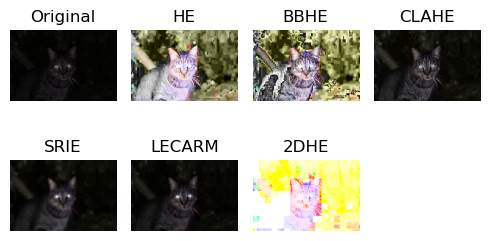

In [18]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# import skfuzzy as fuzz
# from scipy.ndimage import gaussian_filter

# # 1. Brightness Preserving Bi-Histogram Equalization (BBHE)
# def bbhe(v):
#     """
#     Brightness Preserving Bi-Histogram Equalization (BBHE)
#     """
#     mean_intensity = int(np.mean(v))  # Compute the mean intensity as a threshold
#     lower_mask = v <= mean_intensity  # Pixels below or equal to the mean
#     upper_mask = v > mean_intensity   # Pixels above the mean

#     # Initialize result array
#     result = np.zeros_like(v, dtype=np.uint8)

#     # Apply histogram equalization to the lower part
#     if np.any(lower_mask):
#         lower_part = v[lower_mask].flatten().astype(np.uint8)  # Flatten the lower part
#         lower_eq = cv2.equalizeHist(lower_part)
#         result[lower_mask] = lower_eq.reshape(result[lower_mask].shape)

#     # Apply histogram equalization to the upper part
#     if np.any(upper_mask):
#         upper_part = v[upper_mask].flatten().astype(np.uint8)  # Flatten the upper part
#         upper_eq = cv2.equalizeHist(upper_part)
#         result[upper_mask] = upper_eq.reshape(result[upper_mask].shape)

#     return result


# # 2. Contrast Limited Adaptive Histogram Equalization (CLAHE)
# def apply_clahe(v, clip_limit=2.0, tile_grid_size=(8, 8)):
#     clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
#     return clahe.apply(v)

# # 3. Simultaneous Reflectance and Illumination Estimation (SRIE)
# def srie(v, lambda_val=0.01, sigma=2):
#     log_v = np.log1p(v.astype('float32'))
#     illumination = cv2.GaussianBlur(log_v, (0, 0), sigma)
#     reflectance = log_v - illumination
#     enhanced_reflectance = reflectance * lambda_val
#     enhanced_v = np.expm1(illumination + enhanced_reflectance)
#     enhanced_v = cv2.normalize(enhanced_v, None, 0, 255, cv2.NORM_MINMAX)
#     return enhanced_v.astype('uint8')

# # 4. Low-light Enhancement by Contrast-Adaptive Retinex Model (LECARM)
# def lecarm(v):
#     log_v = np.log1p(v.astype('float32') / 255.0)
#     enhanced_log = cv2.GaussianBlur(log_v, (5, 5), 0)
#     return cv2.normalize(np.expm1(enhanced_log), None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

# # 5. 2D Histogram Equalization (2DHE)
# def two_dhe(v, window_size=7):
#     histogram = np.zeros((256, 256))
#     M, N = v.shape
#     pad_size = window_size // 2
#     padded_v = np.pad(v, pad_size, mode='reflect')
#     for i in range(M):
#         for j in range(N):
#             center = v[i, j]
#             local_window = padded_v[i:i + window_size, j:j + window_size]
#             for k in range(window_size):
#                 for l in range(window_size):
#                     neighbor = local_window[k, l]
#                     histogram[center, neighbor] += 1
#     cumulative = np.cumsum(histogram.sum(axis=0))
#     mapping = np.interp(np.arange(256), np.linspace(0, 1, 256), cumulative)
#     return cv2.LUT(v, mapping.clip(0, 255).astype('uint8'))

# # Quality Metrics
# def mean_value(image):
#     return np.mean(image)

# def measure_of_enhancement(image, k=7):
#     h, w = image.shape
#     window_h, window_w = h // k, w // k
#     eme = 0
#     for i in range(k):
#         for j in range(k):
#             local_window = image[i * window_h:(i + 1) * window_h, j * window_w:(j + 1) * window_w]
#             min_val = np.min(local_window)
#             max_val = np.max(local_window)
#             if min_val > 0:
#                 eme += 20 * np.log10(max_val / min_val)
#     return eme / (k * k)

# def calculate_niqe(image):
#     """
#     Approximate NIQE using local means, variances, and gradients.
#     """
#     # Normalize the image
#     image = image / 255.0

#     # Compute local mean, variance, and gradient
#     mu = gaussian_filter(image, sigma=7)
#     sigma_sq = gaussian_filter(image**2, sigma=7) - mu**2
#     gradient = np.sqrt(gaussian_filter(image, sigma=1, order=1)**2 +
#                        gaussian_filter(image, sigma=1, order=0)**2)

#     # Combine metrics to compute NIQE
#     niqe_value = np.mean(np.sqrt(mu**2 + sigma_sq + gradient**2))
#     return niqe_value

# # Main Script
# def enhance_image(image_path):
#     # Read the image
#     image = cv2.imread(image_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#     h, s, v = cv2.split(hsv)

#     # Apply Enhancement Techniques
#     he_image = cv2.merge((h, s, cv2.equalizeHist(v)))
#     bbhe_image = cv2.merge((h, s, bbhe(v)))
#     clahe_image = cv2.merge((h, s, apply_clahe(v)))
#     srie_image = cv2.merge((h, s, srie(v)))
#     lecarm_image = cv2.merge((h, s, lecarm(v)))
#     two_dhe_image = cv2.merge((h, s, two_dhe(v)))

#     # Convert back to RGB
#     he_image = cv2.cvtColor(he_image, cv2.COLOR_HSV2RGB)
#     bbhe_image = cv2.cvtColor(bbhe_image, cv2.COLOR_HSV2RGB)
#     clahe_image = cv2.cvtColor(clahe_image, cv2.COLOR_HSV2RGB)
#     srie_image = cv2.cvtColor(srie_image, cv2.COLOR_HSV2RGB)
#     lecarm_image = cv2.cvtColor(lecarm_image, cv2.COLOR_HSV2RGB)
#     two_dhe_image = cv2.cvtColor(two_dhe_image, cv2.COLOR_HSV2RGB)

#     # List of all images and their titles
#     images = [image, he_image, bbhe_image, clahe_image, srie_image, lecarm_image, two_dhe_image]
#     titles = ["Original", "HE", "BBHE", "CLAHE", "SRIE", "LECARM", "2DHE"]

#     # Metrics Evaluation
#     print("\nQuality Metrics (MV, EME, NIQE):")
#     for title, img in zip(titles, images):
#         gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#         mv = mean_value(gray)
#         eme = measure_of_enhancement(gray)
#         niqe_score = calculate_niqe(gray)
#         print(f"{title}: MV={mv:.2f}, EME={eme:.2f}, NIQE={niqe_score:.2f}")

#     # Display all results
#     plt.figure(figsize=(5, 3))
#     for i, (title, img) in enumerate(zip(titles, images), 1):
#         plt.subplot(2, 4, i)
#         plt.title(title)
#         plt.imshow(img)
#         plt.axis('off')
#     plt.tight_layout()
#     plt.show()

# # Run the script
# enhance_image("cat.jpeg")


Quality Metrics (MV, EME, NIQE):
Original: MV=10.77, EME=15.00, NIQE=0.05
HE: MV=115.77, EME=16.63, NIQE=0.49
BBHE: MV=114.63, EME=10.29, NIQE=0.50
CLAHE: MV=18.19, EME=18.86, NIQE=0.08
SRIE: MV=30.79, EME=16.58, NIQE=0.13
LECARM: MV=14.69, EME=16.91, NIQE=0.07
2DHE: MV=200.03, EME=6.34, NIQE=0.79


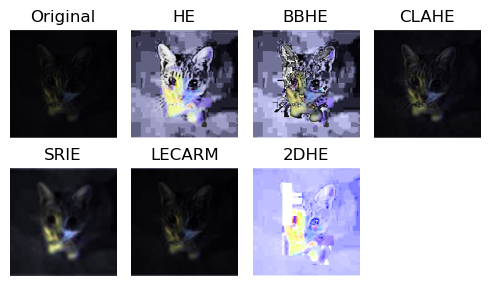

In [19]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.ndimage import gaussian_filter

# # 1. Brightness Preserving Bi-Histogram Equalization (BBHE)
# # def bbhe(v):
# #     mean_intensity = np.mean(v)
# #     lower_mask = v <= mean_intensity
# #     upper_mask = v > mean_intensity
# #     lower_v = v.copy()
# #     upper_v = v.copy()
# #     lower_v[~lower_mask] = 0
# #     upper_v[~upper_mask] = 0
# #     lower_eq = cv2.equalizeHist(lower_v)
# #     upper_eq = cv2.equalizeHist(upper_v)
# #     v_result = lower_eq + upper_eq
# #     return v_result
# def bbhe(v):
#     """
#     Brightness Preserving Bi-Histogram Equalization (BBHE)
#     """
#     mean_intensity = int(np.mean(v))  # Compute the mean intensity as a threshold
#     lower_mask = v <= mean_intensity  # Pixels below or equal to the mean
#     upper_mask = v > mean_intensity   # Pixels above the mean

#     # Initialize result array
#     result = np.zeros_like(v, dtype=np.uint8)

#     # Apply histogram equalization to the lower part
#     if np.any(lower_mask):
#         lower_part = v[lower_mask].flatten().astype(np.uint8)  # Flatten the lower part
#         lower_eq = cv2.equalizeHist(lower_part)
#         result[lower_mask] = lower_eq.reshape(result[lower_mask].shape)

#     # Apply histogram equalization to the upper part
#     if np.any(upper_mask):
#         upper_part = v[upper_mask].flatten().astype(np.uint8)  # Flatten the upper part
#         upper_eq = cv2.equalizeHist(upper_part)
#         result[upper_mask] = upper_eq.reshape(result[upper_mask].shape)

#     return result


# # 2. Contrast Limited Adaptive Histogram Equalization (CLAHE)
# def apply_clahe(v, clip_limit=2.0, tile_grid_size=(8, 8)):
#     clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
#     return clahe.apply(v)

# # 3. Simultaneous Reflectance and Illumination Estimation (SRIE)
# def srie(v, lambda_val=0.01, sigma=2):
#     log_v = np.log1p(v.astype('float32'))
#     illumination = cv2.GaussianBlur(log_v, (0, 0), sigma)
#     reflectance = log_v - illumination
#     enhanced_reflectance = reflectance * lambda_val
#     enhanced_v = np.expm1(illumination + enhanced_reflectance)
#     enhanced_v = cv2.normalize(enhanced_v, None, 0, 255, cv2.NORM_MINMAX)
#     return enhanced_v.astype('uint8')

# # 4. Low-light Enhancement by Contrast-Adaptive Retinex Model (LECARM)
# def lecarm(v):
#     log_v = np.log1p(v.astype('float32') / 255.0)
#     enhanced_log = cv2.GaussianBlur(log_v, (5, 5), 0)
#     return cv2.normalize(np.expm1(enhanced_log), None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

# # 5. 2D Histogram Equalization (2DHE)
# def two_dhe(v, window_size=7):
#     histogram = np.zeros((256, 256))
#     M, N = v.shape
#     pad_size = window_size // 2
#     padded_v = np.pad(v, pad_size, mode='reflect')
#     for i in range(M):
#         for j in range(N):
#             center = v[i, j]
#             local_window = padded_v[i:i + window_size, j:j + window_size]
#             for k in range(window_size):
#                 for l in range(window_size):
#                     neighbor = local_window[k, l]
#                     histogram[center, neighbor] += 1
#     cumulative = np.cumsum(histogram.sum(axis=0))
#     mapping = np.interp(np.arange(256), np.linspace(0, 1, 256), cumulative)
#     return cv2.LUT(v, mapping.clip(0, 255).astype('uint8'))

# # Quality Metrics
# def mean_value(image):
#     return np.mean(image)

# def measure_of_enhancement(image, k=7):
#     h, w = image.shape
#     window_h, window_w = h // k, w // k
#     eme = 0
#     for i in range(k):
#         for j in range(k):
#             local_window = image[i * window_h:(i + 1) * window_h, j * window_w:(j + 1) * window_w]
#             min_val = np.min(local_window)
#             max_val = np.max(local_window)
#             if min_val > 0:
#                 eme += 20 * np.log10(max_val / min_val)
#     return eme / (k * k)

# def calculate_niqe(image):
#     """
#     Approximate NIQE using Gaussian filtering and local statistics.
#     """
#     image = image / 255.0  # Normalize the image
#     mu = gaussian_filter(image, sigma=7)
#     sigma_sq = gaussian_filter(image**2, sigma=7) - mu**2
#     sharpness = np.var(image - gaussian_filter(image, sigma=1))
#     return np.mean(mu + sigma_sq + sharpness)

# # Main Script
# def enhance_image(image_path):
#     # Read the image
#     image = cv2.imread(image_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#     h, s, v = cv2.split(hsv)

#     # Apply Enhancement Techniques
#     he_image = cv2.merge((h, s, cv2.equalizeHist(v)))
#     bbhe_image = cv2.merge((h, s, bbhe(v)))
#     clahe_image = cv2.merge((h, s, apply_clahe(v)))
#     srie_image = cv2.merge((h, s, srie(v)))
#     lecarm_image = cv2.merge((h, s, lecarm(v)))
#     two_dhe_image = cv2.merge((h, s, two_dhe(v)))

#     # Convert back to RGB
#     he_image = cv2.cvtColor(he_image, cv2.COLOR_HSV2RGB)
#     bbhe_image = cv2.cvtColor(bbhe_image, cv2.COLOR_HSV2RGB)
#     clahe_image = cv2.cvtColor(clahe_image, cv2.COLOR_HSV2RGB)
#     srie_image = cv2.cvtColor(srie_image, cv2.COLOR_HSV2RGB)
#     lecarm_image = cv2.cvtColor(lecarm_image, cv2.COLOR_HSV2RGB)
#     two_dhe_image = cv2.cvtColor(two_dhe_image, cv2.COLOR_HSV2RGB)

#     # List of all images and their titles
#     images = [image, he_image, bbhe_image, clahe_image, srie_image, lecarm_image, two_dhe_image]
#     titles = ["Original", "HE", "BBHE", "CLAHE", "SRIE", "LECARM", "2DHE"]

#     # Metrics Evaluation
#     print("\nQuality Metrics (MV, EME, NIQE):")
#     for title, img in zip(titles, images):
#         gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#         mv = mean_value(gray)
#         eme = measure_of_enhancement(gray)
#         niqe_score = calculate_niqe(gray)
#         print(f"{title}: MV={mv:.2f}, EME={eme:.2f}, NIQE={niqe_score:.2f}")

#     # Display all results
#     plt.figure(figsize=(5, 3))
#     for i, (title, img) in enumerate(zip(titles, images), 1):
#         plt.subplot(2, 4, i)
#         plt.title(title)
#         plt.imshow(img)
#         plt.axis('off')
#     plt.tight_layout()
#     plt.show()

# # Run the script
# enhance_image("cat_im.jpg")